# Lake Color Response to Wildfire

### By Lauren Kremer

May 3, 2021

Forest composition and structure in the Colorado Front Range has been altered by changes to wildfire regimes, especially increased fire severity (Chambers et al. 2016, Malone et al. 2016, Coop et al. 2020 and others). Subsequently, reduced post-fire tree canopy regrowth often results in chronic impacts to upland ecological function and water quality. Vegetation within forested water catchments regulates water quality through retention and release of nutrients. However, vegetation mortality due to wildfire instantaneously reduces plant demand of nutrients (Rhoades et al. 2019) and in combination with hydrophobic soils (Reale et al. 2015), results in high post-fire erosional sediment and nutrient inputs to headwater streams and may have potentially similar or more severe consequences for lakes (McCullough et al. 2018). Unlike streams and rivers, lakes have much longer water residence times than streams which may result in prolonged fire effects. This is a concern for the US. Southwest as many communities, including the Colorado Front Range, rely on forested montane watersheds for clean drinking water (Figure 1). Water clarity and color can be used as proxies for water quality because they respond to ecological processes within the watershed (Topp et al. 2020). Gardner et al. (2020) and Topp et al. (2020) have demonstrated that long term and seasonal changes in water clarity and color be identified using NIR/red and blue/green ratios, as well as color indices (e.g. the Forel-Ule Color Index (Wang et al. 2015)) collected from Landsat imagery.  

### The Cheesman Reservior in the Hayman burn area, near Pine, Colorado.
![abandoned](https://upload.wikimedia.org/wikipedia/commons/b/b5/Cheesman_Dam_at_Cheesman_Reservoir.jpg)

*Figure 1.* The Cheesman Reservoir is an example of montane water storage that serves the Denver metro area. 

In an effort to determine if post-wildfire changes to lake water quality can be detected with remote sensing tools, this project has two objectives: 1. to determine if post-wildfire changes to lake color can be detected with Landsat imagery and 2. to identify watershed characteristics that drive changes in lake color. 

### Methods:

There are a several of recently developed datasets that match landsat observations to *in-situ* or on-the-ground field measurements for waterbodies within the continental United States (i.e. LimnoSat by Topp et al. 2020, AquaSat by Ross et al. 2018).  LimnoSat offers the 'deepest' point caluclation for each lake within the HydroLAKES dataset, extracts summary optical properties surrounding each point from Landsat 5, 7, and 8, and offeres a dataset of reflectance values that have been standardized across sensors.   
I subset LimnoSat's deepest point shapefile, an asset available through [Google Earth Engine](https://code.earthengine.google.com/4b49c096f90206995d89b87eb528a386)  to identify lakes within Colorado and matched these points to the [LimnoSat](https://zenodo.org/record/4139695) reflectance dataset.
The lake dataset that I used provided a point for the deepest region of each lake, so I built a 2km buffer for each of those points that will serve as a proxy for the catchment area. 

Then, using the Monitoring Trends in Burn Severity [burn extent shapefiles](https://www.mtbs.gov/direct-download) and an overlap function in Python, I to determined which Colorado lakes lied within burn perimeters (Figure 2).  

In [ ]:
# Import needed packages

import earthpy as et
import os
import io
import pandas as pd
import geopandas as gpd
import numpy as np
import requests
import ee
import zipfile
import pyproj
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.ops import transform
import matplotlib.pyplot as plt
from functools import partial
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns


# Import a Colorado shapefile

url = 'https://opendata.arcgis.com/datasets/4402a8e032ed49eb8b37fd729e4e8f03_9.geojson'
colo_shp = gpd.read_file(url)

# Make sure appropriate crs for Colorado distances
colo_shp = colo_shp.set_crs(epsg=4326)

# Set working directory

# if the desired path exists:
data_dir = os.path.join(et.io.HOME, 'Dropbox',
                        'CU Earth DATA Certificate 2021', 'earthlab_project')
if os.path.exists(data_dir):
    # set working directory:
    os.chdir(data_dir)
else:
    os.makedirs(data_dir)
    os.chdir(data_dir)

# Download MTBS shapefile

url = 'https://edcintl.cr.usgs.gov/downloads/sciweb1/shared/MTBS_Fire/data/composite_data/burned_area_extent_shapefile/mtbs_perimeter_data.zip'
local_path = 'tmp/'
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall(path=local_path)  # extract to folder
filenames = [y for y in sorted(z.namelist()) for ending in [
    'dbf', 'prj', 'shp', 'shx'] if y.endswith(ending)]
dbf, prj, shp, shx = [filename for filename in filenames]
mtbs_polys = gpd.clip(gpd.read_file(
    local_path + shp).to_crs(colo_shp.crs), colo_shp)


# Download HydroLAKES point data for Colorado
# https://code.earthengine.google.com/4b49c096f90206995d89b87eb528a386
# LimnoSAT deepest points is a Google Earth Engine asset.  This was clipped to
# Colorado boundaries using the script in the link above which exports the asset to Google Drive.

hydro_dp_path = os.path.join("data", "hydro_deep_points_co.shp")
hydro_points = gpd.read_file(hydro_dp_path, bbox=colo_shp).to_crs(colo_shp.crs)


# Download LimnoSAT and MTBS image data

#url = "https://zenodo.org/record/4139695/files/srCorrected_us_hydrolakes_dp_20200628.feather"
#limnosat = pd.read_feather(url)
# Couldn't figure out how to download feather from url. Worked better to download feather locally

limnosat_path = os.path.join(
    "data", "srCorrected_us_hydrolakes_dp_20200628.feather")
limnosat = pd.read_feather(limnosat_path, columns=None,
                           use_threads=True, storage_options=None)

# Conversion of shared column to integer before merging
limnosat['Hylak_id'] = limnosat['Hylak_id'].astype(int)
# = limnosat.loc[limnosat['Hylak_id'] == hydro_points['Hylak_id']]

subset_limno = limnosat[limnosat.set_index(['Hylak_id']).index.isin(
    hydro_points.set_index(['Hylak_id']).index)]  # subset limnoSAT dataset to lake IDs found
# in Colorado HydroLAKES points

hydro_points.set_index(['Hylak_id'])

# Merge with `merge` method on shared variable (Hylak_id):
limnosat_pnts = hydro_points.merge(subset_limno, on='Hylak_id')

# Add buffer to each lake point
limnosat_pnts['geometry'] = limnosat_pnts.geometry.buffer(2000)

# Change catagory datatypes to strings
limnosat_pnts['sat'] = limnosat_pnts['sat'].astype(str)

# Generate merged dataset of fire affected lake points
merged = gpd.overlay(mtbs_polys, limnosat_pnts, how='intersection')

# and plot the output:
fig, ax = plt.subplots(figsize=(16, 12))

mtbs_polys['geometry'].plot(ax=ax,
                            color='red')

limnosat_pnts['geometry'].plot(ax=ax,
                               color='blue',
                               alpha=0.5)

merged['geometry'].plot(ax=ax, color='chartreuse',
                        #edgecolor = 'black',
                        linewidth=1,
                        alpha=0.5)

ax.set(facecolor="gainsboro")
# .set_axis_off()

/Users/laurenkremer/miniconda3/envs/earth-analytics-python/lib/python3.8/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
<ipython-input-7-7268bee921f8>:91: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  limnosat_pnts['geometry'] = limnosat_pnts.geometry.buffer(2000)


*Figure 2.* Colorado lake 'deepest points' and wildfire burn perimeters since 1984.  Green points indicate regions where lake polygons and fire polygons overlap. 

### Observing the Data

From the overlapping points, tablular data from the LimnoSat dataset and burn initiation dates of the MTBS dataset were plotted. Lake color was assessed by converting the red, green and blue landsat bands and the angle of reflectance to the Forel Ule index and plotted over time to observe pre- and post-fire index trends. Each landsat image was classifed as pre- or post-fire and the number of days between burn ignition and Landsat image were caluculated to determine distance from fire in days or years. To minimize seasonal effects on lake color, only one or two months at a time were reviewed.  As an example, July and August images are gathered from the dataset for the images below. The index value for all lakes combined did not yield obvious trends post-fire when compared to pre-fire (Figure 3), though some decline in index value may be present.




/Users/laurenkremer/miniconda3/envs/earth-analytics-python/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (2,22) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


2019-08-26 00:00:00
1991-07-01 00:00:00
7


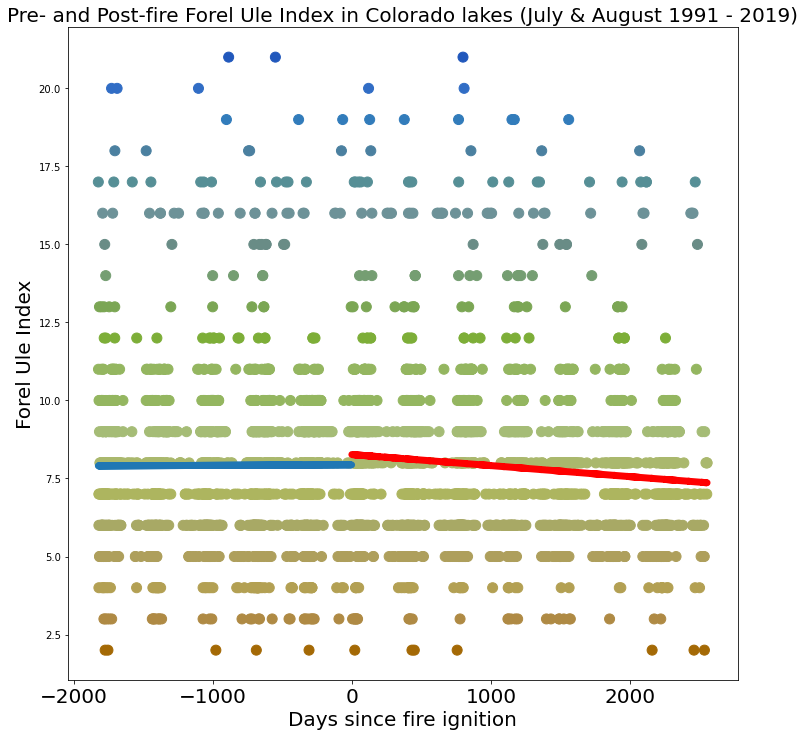

In [2]:
# Make a copy of the geopandas dataframe
merged1 = merged.copy()

# Designate desitnation path
outfp = os.path.join("data", "lake_mtbs_merged_tab.csv")

# Export tabular data after dropping troublesome geometry columns
merged1.drop(columns = ['geometry']).to_csv(outfp)

path_in = os.path.join("data", "lake_mtbs_merged_tab.csv")
# other columns may be dropped here later
colo_tabular = pd.read_csv(path_in).drop(columns=['irwinID'])
#colo_tabular.info()

# Check date structure of ignition date (Ig_Date) and image date (date)
# colo_tabular.info()

# Both are objects after import, convert to dates
colo_tabular['date'] = pd.to_datetime(colo_tabular['date'])
colo_tabular['Ig_Date'] = pd.to_datetime(colo_tabular['Ig_Date'])

# Generate pre or post fire classification of Landsat imagery based on condition
# that image date is before ingition date
colo_tabular['pre_post'] = np.where(
    colo_tabular['date'] < colo_tabular['Ig_Date'], "pre-fire", "post-fire")
# print(colo_tabular.pre_post)

# Generate a calculation for the lapse of time pre- or post fire for plotting
colo_tabular['days_since'] = (colo_tabular['date'] - colo_tabular['Ig_Date'])

# Convert days_since to numerical/integer value that can be plotted
colo_tabular.days_since = colo_tabular.days_since.astype(
    'timedelta64[D]').astype(int)
# print(colo_tabular.days_since)

# Add a image month column for trend monitoring
colo_tabular['img_month'] = pd.DatetimeIndex(colo_tabular['date']).month

# Add a classification that identifies the number of years since the fire.
# This method allows for manual adjustment of year assingment
col = colo_tabular['days_since']
conditions = [(col < 2920) & (col >= 2555),
              (col < 2555) & (col >= 2190),
              (col < 2190) & (col >= 1825),
              (col < 1825) & (col >= 1460),
              (col < 1460) & (col >= 1095),
              (col < 1095) & (col >= 730),
              (col < 730) & (col >= 365),
              (col >= 0) & (col < 365),
              (col < 0) & (col >= -365),
              (col < -365) & (col >= -730),
              (col < -703) & (col >= -1095),
              (col < -1095) & (col >= -1460),
              (col < -1460) & (col >= -1825),
              (col < -1825) | (col >= -2190),
              (col < -2190) | (col >= -2555),
              (col < -2555) | (col >= -2920)]
choices = ['8', '7', '6', '5', '4', '3', '2', '1',
           '0', '-1', '-2', '-3', '-4', '-5', '-6', '-7']
colo_tabular['years_since'] = np.select(conditions, choices, default='meh')
colo_tabular['years_since'] = colo_tabular['years_since'].astype(int)

# When exploring data, can subset by month to limit seasonal effects
plot_subset = colo_tabular.loc[colo_tabular['img_month'] == 7]

plot_subset = plot_subset.loc[(plot_subset['days_since'] < 2920) & (plot_subset['days_since'] > -2920)]


# Add forel ule index to dWL for visualization
col = colo_tabular['dWL']
conditions = [(col == 583) & (col > 581),
              (col <= 581) & (col > 579),
              (col <= 579) & (col > 577),
              (col <= 577) & (col > 575),
              (col <= 575) & (col > 573),
              (col <= 573) & (col > 571),
              (col <= 571) & (col > 570),
              (col <= 570) & (col > 569),
              (col <= 569) & (col > 568),
              (col <= 568) & (col > 567),
              (col <= 567) & (col > 564),
              (col <= 564) & (col > 559),
              (col <= 559) & (col > 549),
              (col <= 549) & (col > 530),
              (col <= 530) & (col > 509),
              (col <= 509) & (col > 495),
              (col <= 495) & (col > 489),
              (col <= 489) & (col > 485),
              (col <= 485) & (col > 480),
              (col <= 480) & (col > 475),
              (col > 470) & (col <= 475)]


choices = ['21', '20', '19', '18', '17', '16', '15', '14', '13', '12', '11',
           '10', '9', '8', '7', '6', '5', '4', '3', '2', '1']
colo_tabular['fui'] = np.select(conditions, choices, default='1001')
colo_tabular['fui'] = pd.to_numeric(colo_tabular['fui'], errors='coerce')

choices = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k',
           'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u']
colo_tabular['fui_color'] = np.select(conditions, choices, default='v')

# Check that new or converted values make sense
colo_tabular[['Ig_Date', 'date', 'pre_post',
              'days_since', 'img_month', 'years_since', 'dWL', 'fui']].head

# colo_tabular.dtypes


# Create a dictionary where you assign each attribute value to a particular color for plotting
fui_colors = {'a':  "#2158bc", 'b': "#316dc5", 'c': "#327cbb", 'd': "#4b80a0", 'e': "#568f96", 'f': "#6d9298",
              'g': "#698c86", 'h': "#759e72", 'i': "#7ba654", 'j': "#7dae38", 'k': "#94b660",
              'l': "#94b660", 'm': "#a5bc76", 'n': "#aab86d", 'o': "#adb55f", 'p': "#a8a965",
              'q': "#ae9f5c", 'r': "#b3a053", 's': "#af8a44", 't': "#a46905", 'u': "#9f4d04", 'v': "#9E250C"}

# Summer observations over timem (where time is relative to fire ignition date)

plot_subset = colo_tabular.loc[(colo_tabular['img_month'] == 7)
                               | (colo_tabular['img_month'] == 8)]

plot_subset = plot_subset.loc[(plot_subset['years_since'] < 8) & (
    plot_subset['years_since'] > -5) & (plot_subset['fui'] != 1001)]

# The years represented in plots may not be evident, add min and max years to plot titles
# CAN ADD THIS TO PLOT TITLE FUNCTION TO PRINT AUTOMATICALLY
max_yr = plot_subset['date'].max()
min_yr = plot_subset['date'].min()
max_lapse = plot_subset['years_since'].max()


# plot_subset.dtypes

# plot fui trends:
# Plots

fig, (ax) = plt.subplots(figsize=(12, 12))

ax.scatter(x=plot_subset['days_since'],
           y=plot_subset['fui'],
           c=plot_subset['fui_color'].apply(lambda x: fui_colors[x]),
           s=100)


# calc the trendlines
pre_fire = plot_subset.loc[(plot_subset['days_since'] < 0)]
post_fire = plot_subset.loc[(plot_subset['days_since'] >= 0)]

z = np.polyfit(pre_fire['days_since'], pre_fire['fui'], 1)
p = np.poly1d(z)
ax.plot(pre_fire['days_since'], p(pre_fire['days_since']), linewidth=7.0)

z = np.polyfit(post_fire['days_since'], post_fire['fui'], 1)
p = np.poly1d(z)
ax.plot(post_fire['days_since'], p(
    post_fire['days_since']), "r--", linewidth=7.0)

ax.set(title='Pre- and Post-fire Forel Ule Index in Colorado lakes (July & August 1991 - 2019)',
       xlabel='Days since fire ignition',
       ylabel='Forel Ule Index')

ax.yaxis.label.set_fontsize(20)
ax.xaxis.label.set_fontsize(20)
ax.title.set_fontsize(20)
ax.tick_params(axis="x", labelsize=20)

*Figure 3.* Forel Ule index trends as a function of time since fire in days. 

To explore further, I looked at the color trends within individual lakes, we can see that the responses and resilience differs among them. If reviewing just July and August images, from the same period of time as the last figure, and on the x-axis, the time since fire is represented in years.  These are just a few lakes in the dataset selected to exemplify the differences in response. The Rampart Reservoir in the Pikes Peak/central region of the state reflects an increase in index value, whereas the Seaman Reservoir in Northern Colorado reflects a decrease, and other lakes may be reflecting an increase in color variability. 



<ipython-input-3-0fc93d827558>:28: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axes[0, 0].set_xticks([], [])
<ipython-input-3-0fc93d827558>:44: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axes[0, 1].set_yticks([], [])
<ipython-input-3-0fc93d827558>:46: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axes[0, 1].set_xticks([], [])
<ipython-input-3-0fc93d827558>:72: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axes[1, 1].set

Text(0.5, 0, 'Years since fire ignition')

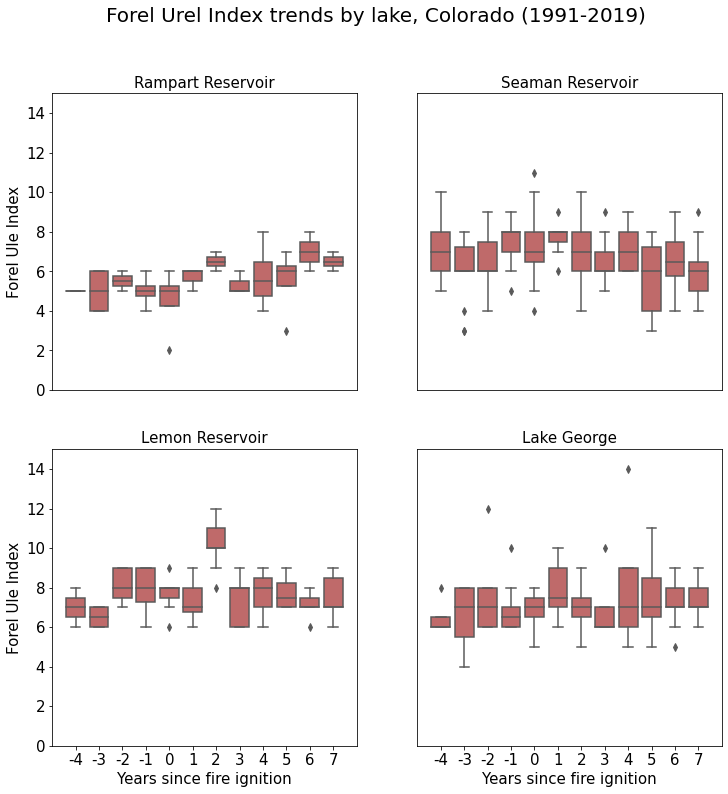

In [3]:
plot_subset = colo_tabular.loc[(colo_tabular['years_since'] < 8) & (
    colo_tabular['years_since'] > -5) & (colo_tabular['fui'] != 1001)]
plot_subset = plot_subset.loc[(colo_tabular['img_month'] == 7)
                              | (colo_tabular['img_month'] == 8)]


# subset by month
waldo = plot_subset.loc[(plot_subset['Hylak_id'] == 112400)]
seaman = plot_subset.loc[(plot_subset['Hylak_id'] == 1055287)]
george = plot_subset.loc[(plot_subset['Hylak_id'] == 1057228)]
missionary = plot_subset.loc[(plot_subset['Hylak_id'] == 112664)]
spring = plot_subset.loc[(plot_subset['Hylak_id'] == 1056666)]
forbes = plot_subset.loc[(plot_subset['Hylak_id'] == 1058951)]
wrights = plot_subset.loc[(plot_subset['Hylak_id'] == 1057446)]
silver = plot_subset.loc[(plot_subset['Hylak_id'] == 1055734)]
wrights = plot_subset.loc[(plot_subset['Hylak_id'] == 1057446)]

fig, axes = plt.subplots(2, 2, figsize=(12, 12))

fig.suptitle(
    'Forel Urel Index trends by lake, Colorado (1991-2019)', fontsize=20)

sns.boxplot(ax=axes[0, 0], data=waldo,
            x='years_since', y='fui', color='#CD5C5C')
axes[0, 0].set_title("Rampart Reservoir")
axes[0, 0].set_xlim([-1, 12])
axes[0, 0].set_ylim([0, 15])
axes[0, 0].set_xticks([], [])
axes[0, 0].set_xlabel('')
axes[0, 0].yaxis.label.set_fontsize(15)
axes[0, 0].xaxis.label.set_fontsize(15)
axes[0, 0].title.set_fontsize(15)
axes[0, 0].tick_params(axis="x", labelsize=15)
axes[0, 0].tick_params(axis="y", labelsize=15)
axes[0, 0].set_ylabel('Forel Ule Index')
# sns.swarmplot(ax=axes[0, 0], data=waldo, x='years_since', y='fui',color='#7d0013' )


sns.boxplot(ax=axes[0, 1], data=seaman,
            x='years_since', y='fui', color='#CD5C5C')
axes[0, 1].set_title("Seaman Reservoir")
axes[0, 1].set_xlim([-1, 12])
axes[0, 1].set_ylim([0, 15])
axes[0, 1].set_yticks([], [])
axes[0, 1].set_ylabel('')
axes[0, 1].set_xticks([], [])
axes[0, 1].set_xlabel('')
axes[0, 1].yaxis.label.set_fontsize(15)
axes[0, 1].xaxis.label.set_fontsize(15)
axes[0, 1].title.set_fontsize(15)
axes[0, 1].tick_params(axis="x", labelsize=15)
axes[0, 1].tick_params(axis="y", labelsize=15)

sns.boxplot(ax=axes[1, 0], data=missionary,
            x='years_since', y='fui', color='#CD5C5C')
axes[1, 0].set_title("Lemon Reservoir")
axes[1, 0].set_xlim([-1, 12])
axes[1, 0].set_ylim([0, 15])
axes[1, 0].yaxis.label.set_fontsize(15)
axes[1, 0].xaxis.label.set_fontsize(15)
axes[1, 0].title.set_fontsize(15)
axes[1, 0].tick_params(axis="x", labelsize=15)
axes[1, 0].tick_params(axis="y", labelsize=15)
axes[1, 0].set_xlabel('Years since fire ignition')
axes[1, 0].set_ylabel('Forel Ule Index')

sns.boxplot(ax=axes[1, 1], data=george,
            x='years_since', y='fui', color='#CD5C5C')
axes[1, 1].set_title("Lake George")
axes[1, 1].set_xlim([-1, 12])
axes[1, 1].set_ylim([0, 15])
axes[1, 1].set_yticks([], [])
axes[1, 1].set_ylabel('')
axes[1, 1].yaxis.label.set_fontsize(15)
axes[1, 1].xaxis.label.set_fontsize(15)
axes[1, 1].title.set_fontsize(15)
axes[1, 1].tick_params(axis="x", labelsize=15)
axes[1, 1].tick_params(axis="y", labelsize=15)
axes[1, 1].set_xlabel('Years since fire ignition')

*Figure 4.*. Dispersion of index values by years since fire ignition for July and August color indices. These sites were selected to exemplify different types of color change, where an increase can be observed in Rampart Reservoir, relative to an index decrease in the Seaman Reservoir.  Other sites, like the Lemon Reservoir and Lake George, may reflect increased variability post-fire or little change at all. 

## Next Steps/Future Work

This project will continue over the next six weeks by undertaking several steps to identify the drivers behind the differences in color response among lakes. Within each lake polygon, I will attempt to characterize fire effects by calculating the proportion of each burn severity level and the total area burned.  Additionally, landscape characteristics like vegetation coverage, climate patterns and soil characteristics will be added to the analysis from the Earth Engine API within Python which will allow for data collection among many sources. In-situ data of chlorophyll concentrations from AquaSat will be merged with the burned dataset above and will be used as a response variable to train a random forest model.  From the model output, I hope to identify the most influential drivers of changes to lake color post-fire, and gain an understanding of why lakes may respond differently in terms of remotely sensed color. 

## Works cited:

Chambers, M. E., Fornwalt, P. J., Malone, S. L., & Battaglia, M. A. (2016). Patterns of conifer regeneration following high severity wildfire in ponderosa pine – dominated forests of the Colorado Front Range. Forest Ecology and Management, 378:57-67. doi:10.1016/j.foreco.2016.07.001

Coop, J. D., S. A. Parks, C. S. Stevens-Rumann, S. D. Crausbay, P. E. Higuera, M. D. Hurteau, A. Tepley, E. Whitman, T. Assal, B. M. Collins, K. T. Davis, S. Dobrowski, D. A. Falk, P. J. Fornwalt, P. Z. Fule, B. J. Harvey, V. Kane, C. E. Littlefield, E. Q. Margolis, M. North, M. A. Parisien, S. Prichard, and K. C. Rodman. 2020. Wildfire-Driven Forest Conversion in Western North American Landscapes. Bioscience 70:659-673.

Gardner, J. R., X. Yang, S. N. Topp, M. R. V. Ross, E. H. Altenau, and T. M. Pavelsky. 2021. The Color of Rivers. Geophysical Research Letters 48.

Malone, S. L., Fornwalt, P. J., Battaglia, M. A., Chambers, M. E., Iniguez, J. M., & Sieg, C. H. (2018). Mixed-Severity Fire Fosters Heterogeneous Spatial Patterns of Conifer Regeneration in a Dry Conifer Forest. Forests, 9:1. doi:10.3390/f9010045

McCullough, I.M., Cheruvelil, K.S. Lapierre, J.F., Lottig, N.R. (2019). Do lakes feel the burn? Ecological consequences of increasing exposure of lakes to fire in the continental United States. Global Change Biology 25:9 

Reale, J. K., D. J. Van Horn, K. E. Condon, and C. N. Dahm. 2015. The effects of catastrophic wildfire on water quality along a river continuum. Freshwater Science 34:1426-1442.

Rhoades, C. C., A. T. Chow, T. P. Covino, T. S. Fegel, D. N. Pierson, and A. E. Rhea. 2018. The Legacy of a Severe Wildfire on Stream Nitrogen and Carbon in Headwater Catchments. Ecosystems 22:643-657.

Ross, M. R. V., S. N. Topp, A. P. Appling, X. Yang, C. Kuhn, D. Butman, M. Simard, and T. M. Pavelsky. 2019. AquaSat: A Data Set to Enable Remote Sensing ofWater Quality for InlandWaters. Water Resources Research 55:10012-10025.

Topp, S. N., Pavelsky, T. M., Dugan, D. A., Yang, X., Gardner, J. R. Ross, M.R.V. (2020). Shifting patterns of lake color phenology in over 26,000 US lakes. Earth and Space Science Open Archive.

Wang, S. L., Z. P. Lee, S. L. Shang, J. S. Li, B. Zhang, and G. Lin. 2019. Deriving inherent optical properties from classical water color measurements: Forel-Ule index and Secchi disk depth. Optics Express 27:7642-7655.
